# Time Series Forecasting with ARIMA

_After brushing my basic knowledge of ARIMA with a lot articles, I found this one is quite clearly-explained: https://www.relataly.com/forecasting-beer-sales-with-arima-in-python/2884/_

Also, analysis of tractor sales, http://ucanalytics.com/blogs/wp-content/uploads/2017/08/ARIMA-TimeSeries-Analysis-of-Tractor-Sales.html

And kaggle tutorial

https://timeseriesreasoning.com/contents/regression-with-arima-errors-model/

https://towardsdatascience.com/end-to-end-time-series-analysis-and-forecasting-a-trio-of-sarimax-lstm-and-prophet-part-1-306367e57db8

https://towardsdatascience.com/how-to-forecast-sales-with-python-using-sarima-model-ba600992fa7d

https://towardsdatascience.com/end-to-end-time-series-analysis-and-forecasting-a-trio-of-sarimax-lstm-and-prophet-part-1-306367e57db8

In [1]:
# Libraries
 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"         

import numpy as np
import pandas as pd
from datetime import date, datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns#; sns.set()
sns.set(style="darkgrid")       
plt.figure(figsize=(16, 6))
%matplotlib inline  

#import inflectionm
import pickle

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

## Introduction

ARIMA (Auto-Regressive Integrated Moving Average) is a powerful statistical modeling technique for time series analysis and forecasting. Compared to machine learning, ARIMA is a classical modeling technique that is particularly powerful when the time series being analyzed follows a clear pattern. For example, when the time series exhibits seasonality. Due to its effectiveness, ARIMA is still frequently used in various economic and scientific applications. Examples are forecasting weather data, predicting order quantities, and sales forecasting.

Table of Contents
- Introduction to ARIMA Time Series Modelling
    - Concept of Stationarity
    - Testing for Stationarity
    - What is an (S)ARIMA Model?
- Time Series Forecasting with ARIMA in Python
    - Prerequisites
    - Step #1 Load the Data
    - Step #2 Visualize the Time Series and check it for Stationarity
    - Step #3 Exemplary Differencing and Autocorrelation
    - Step #4 Finding an Optimal Model with Auto-ARIMA
    - Step #5 Simulate the Time Series with in-sample Forecasting
    - Step #6 Generate and Visualize a Sales Forecast
    - Step #7 Measure Prediction Errors
- Summary

### Data

In [5]:
df = pd.read_excel('sales.xlsx')

df.columns = ['week', 'promo', 'units']
df['promo']  = df['promo'].fillna(0)
df['week'] = pd.to_datetime(df['week'])

# black friday
black_friday = ["2018-11-18", "2019-11-24", "2020-11-22", "2021-11-21"]
cyber_monday = ["2018-11-25", "2019-12-1", "2020-11-29", "2021-11-28"]
df['black_friday'] = np.where(df['week'].isin(black_friday), 1, 0)
df['cyber_monday'] = np.where(df['week'].isin(cyber_monday), 1, 0)

df.head()

,week,promo,units,black_friday,cyber_monday
0,2019-01-06,60.0,2151,0,0
1,2019-01-13,0.0,530,0,0
2,2019-01-20,0.0,372,0,0
3,2019-01-27,30.0,1139,0,0
4,2019-02-03,30.0,1581,0,0


### Train vs Test

In [6]:
indexed_df = df.set_index('week')
#indexed_df.tail()

size = int(len(indexed_df) - 13)
train, test = indexed_df[0:size], indexed_df[size:len(indexed_df)]
#history = [x for x in train]
#predictions = list()
train.tail()

,promo,units,black_friday,cyber_monday
week,,,,
2021-08-01,0.0,146,0,0
2021-08-08,0.0,528,0,0
2021-08-15,0.0,393,0,0
2021-08-22,0.0,126,0,0
2021-08-29,0.0,118,0,0


In [7]:
#sales_ts = indexed_df['units']

indexed_df = df.set_index('week')

indexed_df.tail()

sales_ts = train['units']
sales_ts.head(5)

,promo,units,black_friday,cyber_monday
week,,,,
2021-10-31,0.0,338,0,0
2021-11-07,0.0,293,0,0
2021-11-14,0.0,439,0,0
2021-11-21,0.0,894,1,0
2021-11-28,0.0,1519,0,1


week
2019-01-06    2151
2019-01-13     530
2019-01-20     372
2019-01-27    1139
2019-02-03    1581
Name: units, dtype: int64

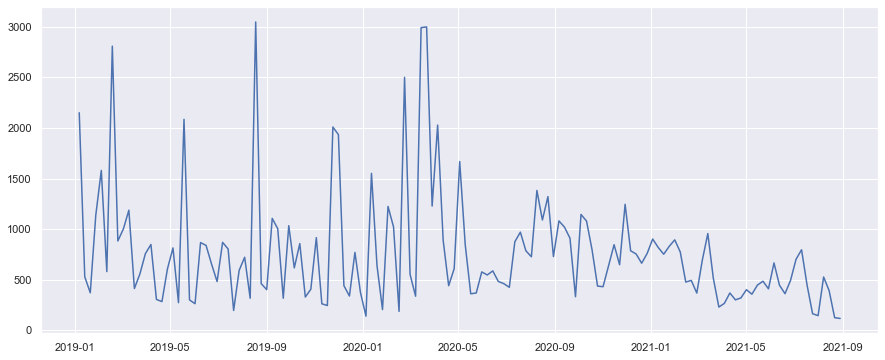

In [8]:
plt.plot(sales_ts)

(array([37., 39., 33., 15.,  4.,  1.,  5.,  0.,  1.,  4.]),
 array([ 118.,  411.,  704.,  997., 1290., 1583., 1876., 2169., 2462.,
        2755., 3048.]),
 <BarContainer object of 10 artists>)

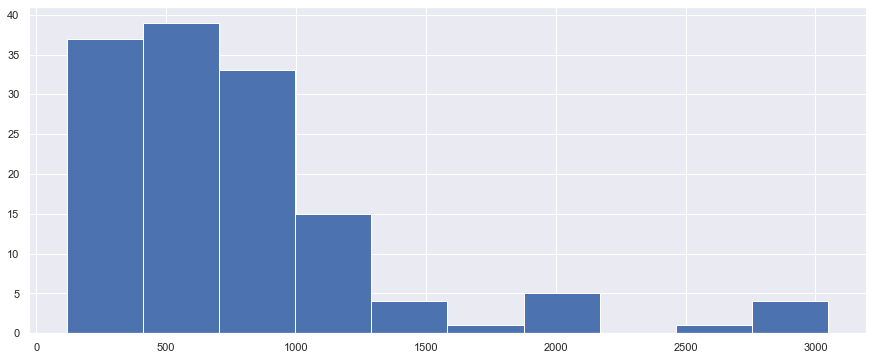

In [34]:
plt.hist(sales_ts)

### Log-transformation & differencing

Difference log transform data to make data stationary on both mean and variance

In [6]:
# resample should not a problem in our case

sales_ts_log = np.log(sales_ts)
# sales_ts_log = np.log10(sales_ts)           # np.power(10, x) to convert it back

# ts_week_log_diff = ts_week_log - ts_week_log.shift()
sales_ts_log_diff = sales_ts_log.diff(periods=1)

# drop nan before do ADF test
sales_ts_log_diff.dropna(inplace=True)

# or just difference no log-transformation
sales_ts_diff = sales_ts.diff(periods=1).dropna()

# plt.plot(sales_ts_log_diff)

Text(0.5, 0, 'Years')

Text(0, 0.5, 'Sales')

Text(0.5, 1.0, 'Original Sales Data')

Text(0.5, 0, 'Years')

Text(0, 0.5, 'Differenced Sales')

Text(0.5, 1.0, '1$^{st}$ Order Differenced Sales')

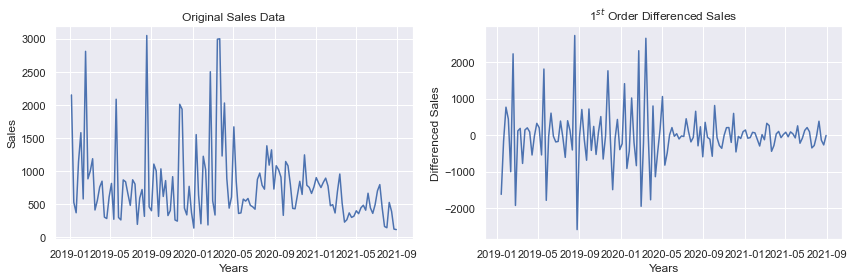

In [7]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)

#axes[0].plot(random_df.index, random_df['Sales'])
axes[0].plot(sales_ts)
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Sales")
axes[0].set_title("Original Sales Data")

#axes[1].plot(sales_ts_log_diff)
# how about just do log_transformation, no differencing
# axes[1].plot(sales_ts_log)
axes[1].plot(sales_ts_diff)
axes[1].set_xlabel("Years")
axes[1].set_ylabel("Differenced Sales")
axes[1].set_title("1$^{st}$ Order Differenced Sales")       # Log(Sales)

plt.tight_layout()
plt.show()

### ADF test

ADF test for stationary

ADF test, unit root, https://towardsdatascience.com/introduction-to-time-series-forecasting-part-2-arima-models-9f47bf0f476b

<font color=red>Indeed, we need 1st-differencing to pass the ADF test, but I have not figure out why the fittedvalues is so wrong with ARIMA(2, 1, 2) </font>

In [8]:
# plot is not very helpful

def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [9]:
test_stationarity(sales_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.627222
p-value                          0.468945
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


In [10]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#test_stationarity(sales_ts_log_diff)
#test_stationarity(sales_ts_log)

test_stationarity(sales_ts_diff)          
# p-value is 0, rejected H0, means it is stationarity already, so log-transformation is not needed

Results of Dickey-Fuller Test:
Test Statistic                 -5.63423
p-value                         0.00000
#Lags Used                     13.00000
Number of Observations Used   124.00000
Critical Value (1%)            -3.48422
Critical Value (5%)            -2.88515
Critical Value (10%)           -2.57936
dtype: float64


In [11]:
test_stationarity(sales_ts_diff) 

Results of Dickey-Fuller Test:
Test Statistic                 -5.63423
p-value                         0.00000
#Lags Used                     13.00000
Number of Observations Used   124.00000
Critical Value (1%)            -3.48422
Critical Value (5%)            -2.88515
Critical Value (10%)           -2.57936
dtype: float64


### ACF & PACF

Create autocorrelation factor (ACF) and partial autocorrelation (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. The idea is to identify presence of AR and MA components in the residuals.

PACF only care about "direct" impact of y_t-2 on y_t, thus used to determined AR part. -- the salmon video

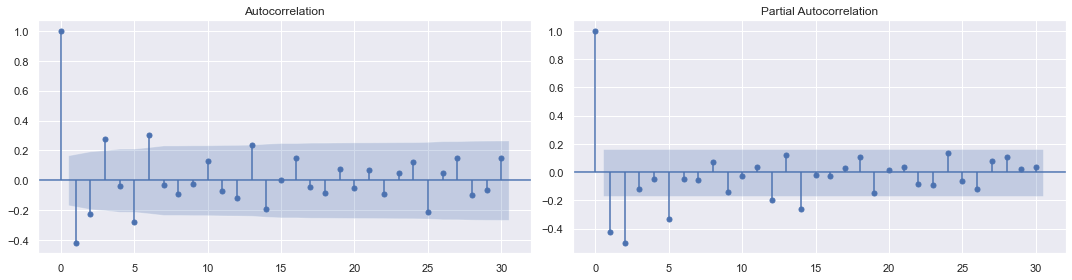

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(15,4))

#fig = plot_acf(sales_ts_log_diff, lags=30, ax=axes[0])          # when not put fit=, shows 3 plots
#fit = plot_pacf(sales_ts_log_diff, lags=30, ax=axes[1])

fig = plot_acf(sales_ts_diff, lags=30, ax=axes[0])          # when not put fit=, shows 3 plots
fit = plot_pacf(sales_ts_diff, lags=30, ax=axes[1])

plt.tight_layout()

_(from the tractor sales example) Since, there are enough spikes in the plots outside the insignificant zone (dotted horizontal lines) we can conclude that the residuals are not random. This implies that there is juice or information available in residuals to be extracted by AR and MA models. Also, there is a seasonal component available in the residuals at the lag 12 (represented by spikes at lag 12). This makes sense since we are analyzing monthly data that tends to have seasonality of 12 months because of patterns in tractor sales._

Inference drawn from the ACF and PACF values

Using the plot we can determine the values for p and q respectively :

- p: the lag value where the PACF cuts off (drop to 0) for the first time. So here p =2.
- q: the lag value where the ACF chart crosses the upper confidence interval for the first time. if you look closely q=1.

### Identification of best fit ARIMA model

In order to fit the time series data with a seasonal ARIMA model, we need to first find the the **values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest such as AIC or BIC**. There are many guidelines and best practices to achieve this goal, yet the correct parametrization of ARIMA models can be a painstaking manual process that requires domain expertise and time. **Auto arima function in forecast package in R** helps us identify the best fit ARIMA model on the fly but in Python we will generate combination of p,d and q to select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model. -- _In Python, there is also a auto arima library, but seems not working well_

This technique is known as **"grid search"** where we iteratively explore different combinations of parameters. For each such combination of parameters, we try to fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess AIC or BIC score. The model with the best score wins and the parmeters for that model are the optimal parmeters.

The best fit model is selected based on **Akaike Information Criterion (AIC)**, and **Bayesian Information Criterion (BIC)** values. **The idea is to choose a model with minimum AIC and BIC values**.

**Akaike Information Criterion (AIC) - AIC is an effort to balance the model between goodness-of-fit and number of parameters used in the model.** This is similar to the balancing act between income and cost of a company so that the debs of the company is optimized (Debt = Cost - Income). As a modeler, we care about the maximum goodness of fit (income) with the minimum number of parameters (cost).

$$AIC=2K−2ln(L) $$

For the given model, L in the above formula is the maximized value of the likelihood function representing goodness-of-fit, and K the number of estimated parameters. Like our debts, we want to keep AIC value at the minimum to choose the best possible model. Bayesian Information Criterion (BIC) is another variant of AIC and is used for the same purpose of best fit model selection. For the best possible model selection, we want to look at AIC, BIC, and AICc (AIC with sample correction) if all these values are minimum for a given model. With increasing parameters K will increase and hence AIC increases. While with the goodness of the fit L increases thus decreasing AIC.

In [13]:
#exog_ts = indexed_df[['promo', 'black_friday', 'cyber_monday']]
exog_ts = train[['promo', 'black_friday', 'cyber_monday']]
exog_ts.tail()

,promo,black_friday,cyber_monday
week,,,
2021-08-01,0.00000,0,0
2021-08-08,0.00000,0,0
2021-08-15,0.00000,0,0
2021-08-22,0.00000,0,0
2021-08-29,0.00000,0,0


In [14]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

<font color=blue>seasonality with weekly data </font>

Weekly data is difficult to work with because the seasonal period (the number of weeks in a year) is both large and non-integer. The average number of weeks in a year is 52.18. Most of the methods we have considered require the seasonal period to be an integer. Even if we approximate it by 52, most of the methods will not handle such a large seasonal period efficiently.

The simplest approach is to use an STL decomposition along with a non-seasonal method applied to the seasonally adjusted data (as discussed in Chapter 6). Here is an example using weekly data on US finished motor gasoline products supplied (in millions of barrels per day) from February 1991 to May 2005.

https://otexts.com/fpp2/weekly.html

In [25]:
import sys
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts,
                                                   exog = exog_ts,
                                                   order = param,
                                                   trend='c',
                                                   #seasonal_order = param_seasonal,
                                                   enforce_stationarity=True,
                                                   enforce_invertibility=True)
            results = temp_model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue
            
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 1)x(0, 0, 0, 12)12 model - AIC:1988.1942296483808


### ARIMA Model

ARIMA will be surpressed, use SARIMAX for all the models

### ARIMAX - promo + holiday

-- put exog_ts in the grid research

In [17]:
#exog_ts = indexed_df[['promo', 'black_friday', 'cyber_monday']]
exog_ts = train[['promo', 'black_friday', 'cyber_monday']]
exog_ts.tail()

,promo,black_friday,cyber_monday
week,,,
2021-08-01,0.00000,0,0
2021-08-08,0.00000,0,0
2021-08-15,0.00000,0,0
2021-08-22,0.00000,0,0
2021-08-29,0.00000,0,0


In [26]:
# exog_ts = sm.add_constant(exog_ts)        # constant seems not important, but makes promo coefficient much smaller

model = sm.tsa.statespace.SARIMAX(sales_ts, exog=exog_ts, order=(1, 1, 1),  trend='c')   # seasonal_order=(0, 1, 1, 12),    
results = model.fit()       
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  units   No. Observations:                  139
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -987.097
Date:                Fri, 17 Dec 2021   AIC                           1988.194
Time:                        11:32:45   BIC                           2008.685
Sample:                    01-06-2019   HQIC                          1996.521
                         - 08-29-2021                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.0788      3.873     -0.020      0.984      -7.669       7.512
promo           30.5628      1.559     19.609      0.000      27.508      33.618
black_friday  -159.7502    705.622     -0.22

<font color=blue>How to read the regression result?</font>

- The number to look at first in the training summary is the **Ljung-Box test’s statistic and its p-value**. The Ljung-Box helps us determine **if the residual errors of regression are auto-correlated in a statistically significant way**. _In this case, the p value is 0.4 which is significantly higher than 0.05 (95% confidence threshold). So we accept the Null hypothesis of the Ljung-Box test that the residual errors are not auto-correlated._

- Two other things to note in the result: **The Jarque-Bera test of normality** has yielded a vanishingly small p-value implying a rejection of the Null hypothesis at a > 99.99% confidence level. The Null hypothesis being that the regression errors are normally distributed. This is probably because the errors are highly kurtotic (note that the Kurtosis=7.49 as against the 3.0 that it should have been for a normal distribution). Note also that the errors are not at all skewed (skewness=0.04 as against 0.0 for normally distributed errors).

- The regression errors are also heteroskedastic i.e. they have non-constant variance. This is evidenced by the vanishingly small p-value of the H-test, but there are some things you can do to fix that.

### Residual diagnostics

Plot ACF and PACF for residuals of ARIMA model to ensure no more information is left for extraction

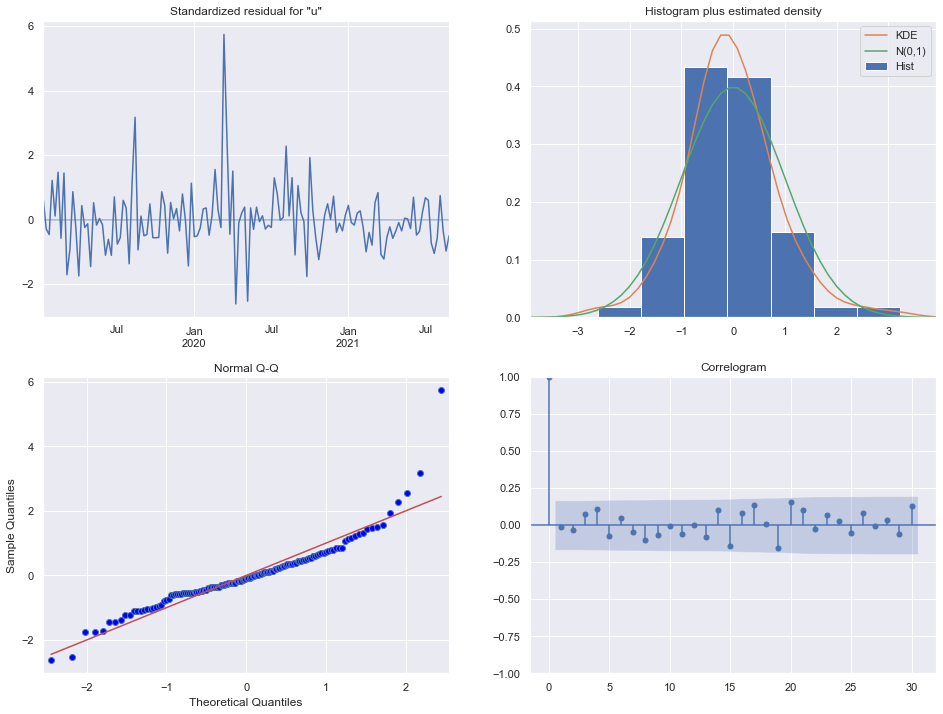

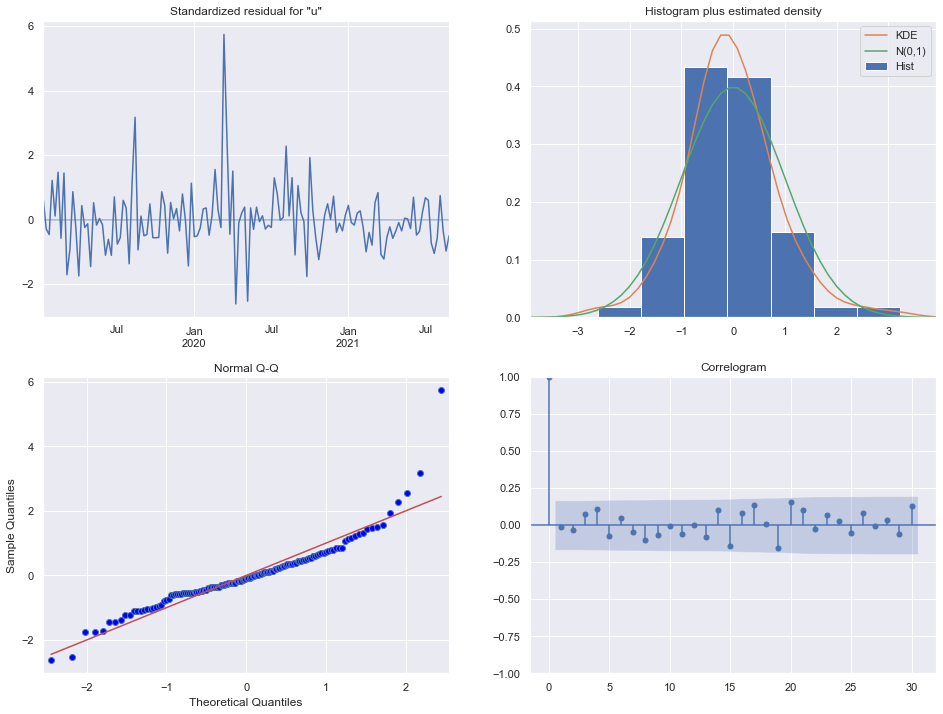

In [27]:
results.plot_diagnostics(lags=30, figsize=(16,12))
#plt.show()
# plots displaced twice

We need to ensure that the **residuals of our model are uncorrelated and normally distributed with zero-mean** -- _basically **white noise**_. If it is not that it signifies that the model can be further improved and we repeat the process with the residuals.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

- The KDE plot of the residuals on the top right is almost similar with the normal distribution.
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations coupled with the fact that there are no spikes outside the insignificant zone for both ACF and PACF plots lead us to conclude that that residuals are random with no information or juice in them and our model produces a satisfactory fit that could help us understand our time series data and forecast future values. It seems that our ARIMA model is working fine.

### Predictions - fittedvalues

predict sales on in-sample date using the best fit ARIMA model, and find out how close is the model prediction on the in-sample data to the actual truth.

In-sample, out-sample prediction, https://stackoverflow.com/questions/62819758/in-sample-prediction-interval-for-arima-in-python

```
from statsmodels.tsa.api import SARIMAX
model = SARIMAX(timeseries, order=(1, 0, 6))
results = model.fit()

pred = results.get_prediction(start=..., end=...)
print(pred.predicted_mean)        # prediction
print(pred.conf_int(alpha=0.05))  # confidence interval

fcast = results.get_forecast(steps=...)
print(fcast.predicted_mean)        # forecast
print(fcast.conf_int(alpha=0.05))  # confidence interval
```

In [20]:
predictions = results.get_prediction(start='2019-01-06', end='2021-08-29', exog=exog_ts, alpha=0.05) 
predictions = predictions.summary_frame()
predictions

units,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-01-06,1824.31101,1495.85417,-1107.50930,4756.13132
2019-01-13,315.31707,1111.75009,-1863.67307,2494.30722
2019-01-20,513.98213,1110.97081,-1663.48064,2691.44491
2019-01-27,1283.48245,1110.75197,-893.55141,3460.51631
2019-02-03,1144.89679,1110.69108,-1032.01773,3321.81131
...,...,...,...,...
2021-08-01,282.27423,325.03393,-354.78056,919.32903
2021-08-08,362.16460,324.99038,-274.80484,999.13405
2021-08-15,429.50571,324.95575,-207.39586,1066.40727
2021-08-22,409.30745,324.92868,-227.54105,1046.15596


<AxesSubplot:xlabel='week'>

Text(0.5, 0, 'Week')

Text(0, 0.5, 'Units')

Text(0.5, 1.0, 'Printer Sales vs Forecasts')

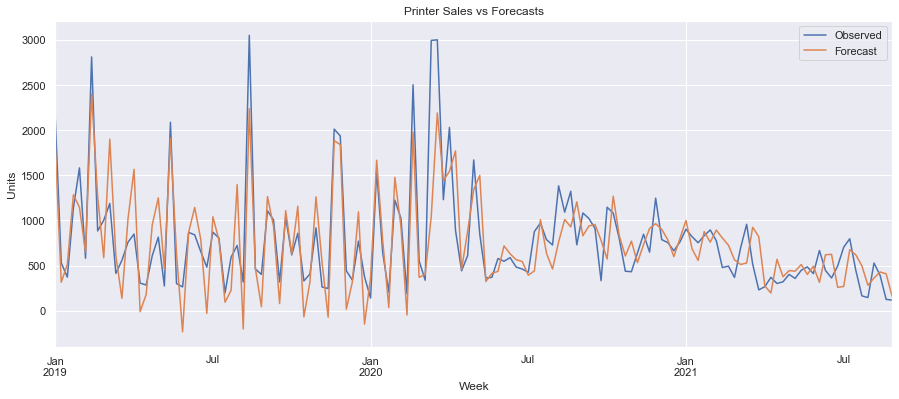

In [21]:
axis = sales_ts.plot(label='Observed', figsize=(15, 6))
# predictions
predictions['mean'].plot(ax=axis, label='Forecast')       # , alpha=0.7
#axis.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
#axis.fill_betweenx(axis.get_ylim(), pd.to_datetime('2019-01-06'), sales_ts.index[-1], alpha=.1, zorder=-1)
axis.set_xlabel('Week')
axis.set_ylabel('Units')
axis.set_title('Printer Sales vs Forecasts')
plt.legend(loc='best')
plt.show()
plt.close()

### Forecast

forecast sales using the best fit ARIMA model, to predict sales for next half year through the above model
- forecast method gives only point forecasts
- fet_forecast method is more general, and also allows constructing confidence intervals

In [28]:
exog_future = test[['promo', 'black_friday', 'cyber_monday']]
# Get forecast 26 steps (26 weeks, half year) ahead in future
n_steps = len(exog_future)

In [23]:
pred_uc_95 = results.get_forecast(steps=n_steps, exog=exog_future, alpha=0.05) 
pred_uc_95 = pred_uc_95.summary_frame()
pred_uc_95

units,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-09-05,249.67913,324.89435,-387.10210,886.46036
2021-09-12,430.92120,376.04779,-306.11893,1167.96132
2021-09-19,262.04399,395.99294,-514.08791,1038.17589
2021-09-26,121.95731,406.69876,-675.15761,919.07223
2021-10-03,292.38878,414.00264,-519.04148,1103.81904
2021-10-10,233.07600,419.72122,-589.56248,1055.71447
2021-10-17,254.81406,424.89825,-577.97120,1087.59933
2021-10-24,232.69982,429.75826,-609.61090,1075.01054
2021-10-31,348.06049,434.44503,-503.43612,1199.55710
2021-11-07,254.11956,439.02746,-606.35845,1114.59757


<AxesSubplot:xlabel='week'>

<AxesSubplot:xlabel='week'>

Text(0.5, 0, 'Years')

Text(0, 0.5, 'Units')

Text(0.5, 1.0, 'Printer Sales vs Forecasts')

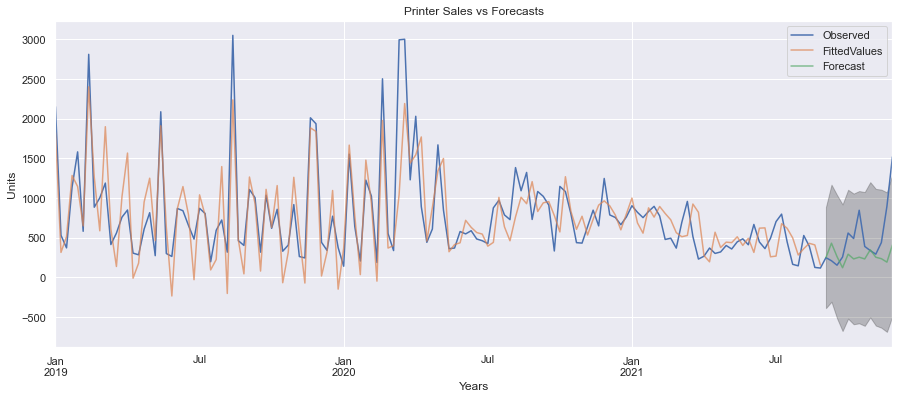

In [33]:
# plot the forecast along with the confidence band

axis = indexed_df['units'].plot(label='Observed', figsize=(15, 6))

predictions['mean'].plot(ax=axis, label='FittedValues', alpha=0.7)

pred_uc_95['mean'].plot(ax=axis, label='Forecast', alpha=0.7)

axis.fill_between(pred_uc_95.index, pred_uc_95['mean_ci_lower'], pred_uc_95['mean_ci_upper'], color='k', alpha=.25)
#axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.75)

axis.set_xlabel('Years')
axis.set_ylabel('Units')
axis.set_title('Printer Sales vs Forecasts')
plt.legend(loc='best')
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error
from numpy import sqrt 

mse = mean_squared_error(test['units'], pred_uc_95['mean'])
print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % mse)

# Root Mean Squared Error
rmse = sqrt(mse)
print('Test RMSE: %.2f' % rmse)



Printing Mean Squared Error of Predictions...
Test MSE: 181337.339921
Test RMSE: 425.84


In [32]:
mse = mean_squared_error(test['units'], pred_uc_95['mean'])
rmse = sqrt(mse)
print('Printing Root Mean Squared Error of Predictions...')
print('Test RMSE: %.2f' % rmse)

Printing Root Mean Squared Error of Predictions...
Test RMSE: 425.84


In [70]:
pred_uc_95['actuals'] = test['units']
pred_uc_95

units,mean,mean_se,mean_ci_lower,mean_ci_upper,actuals
2021-09-05,284.64266,321.10894,-344.71930,914.00462,249
2021-09-12,486.80744,372.02448,-242.34715,1215.96203,210
2021-09-19,331.90587,392.06212,-436.52176,1100.33350,154
2021-09-26,205.10699,402.92116,-584.60397,994.81796,257
2021-10-03,381.06171,410.38699,-423.28202,1185.40543,559
2021-10-10,328.02681,416.26809,-487.84365,1143.89728,490
2021-10-17,357.76082,421.60155,-468.56303,1184.08467,846
2021-10-24,347.53950,426.61421,-488.60898,1183.68798,390
2021-10-31,468.50556,431.45006,-377.12101,1314.13213,338
2021-11-07,383.61302,436.17815,-471.28044,1238.50648,293


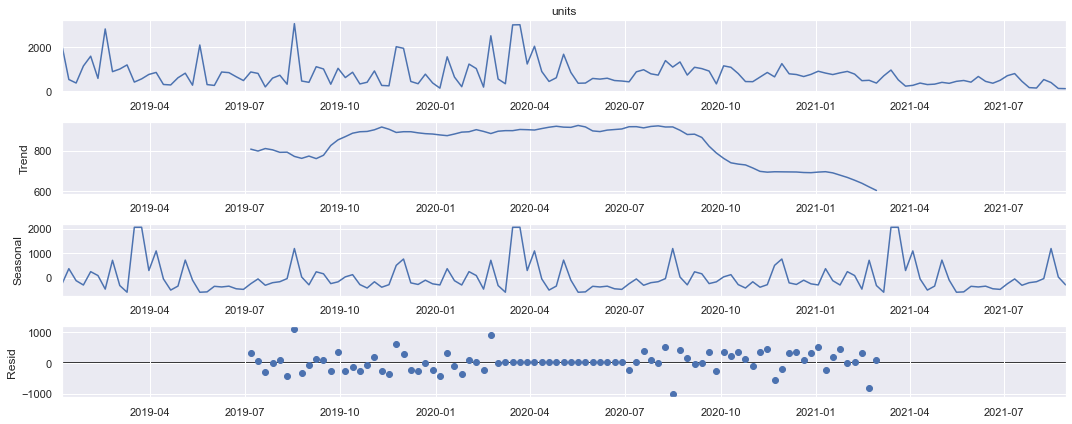

In [71]:
res = sm.tsa.seasonal_decompose(sales_ts)
resplot = res.plot()